# King County

In [1]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido

In [2]:
import pandas as pd
df = pd.read_csv('../datasets/kingcounty/raw/kc_house_data.csv');
df.sample(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
5125,3741600020,20140915T000000,540000.0,3,2.25,2100,20018,1.0,0,4,...,8,1470,630,1948,0,98166,47.4544,-122.366,2410,17196
4545,2771601730,20140629T000000,530000.0,2,1.00,840,3400,1.0,0,2,...,7,840,0,1924,0,98119,47.6403,-122.372,2000,4000
3304,844001140,20141028T000000,206000.0,3,1.00,1050,5233,1.0,0,0,...,5,1050,0,1906,0,98010,47.3106,-121.999,970,7500


In [3]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
syn = Synthetic(df, 
        id="id",
        #category_columns=("condition", "floors", "grade", "view", "waterfront", "yr_built", "yr_renovated", "zipcode", "bathrooms", "bedrooms",),
        category_columns=("condition", "floors", "grade", "view", "waterfront", "zipcode", "bathrooms", "bedrooms",),
        synthetic_folder = "../datasets/kingcounty/synth",
        models=MODELS.keys(),
        n_sample = 21613
)

In [4]:
import torch
torch.cuda.is_available()

True

In [5]:
%%capture
syn.process()
syn.process(remaining_columns=('view','condition','waterfront'))
syn.process_scores()


## Metricas
### Continuas

In [6]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
3,sqft_lot15,"[5000, 4000, 6000, 7200, 4800]","[427, 357, 289, 211, 145]","[0.019756627955397215, 0.01651783648729931, 0....",False,21613.0,0.0,12768.455652,185.725530,13132.471001,...,0.019757,7620.0000,886.000000,1191.240000,1999.2000,5100.000,10083.000,3.706280e+04,1.576870e+05,3.029932e+05
5,sqft_living15,"[1540, 1440, 1560, 1500, 1460]","[197, 195, 192, 181, 169]","[0.009114884560218387, 0.009022347661129875, 0...",False,21613.0,0.0,1986.552492,4.662094,1995.690029,...,0.009115,1840.0000,746.120000,950.000000,1140.0000,1490.000,2360.000,3.300000e+03,4.080000e+03,5.011640e+03
6,sqft_living,"[1300, 1400, 1440, 1660, 1010]","[138, 135, 133, 129, 129]","[0.0063850460371072965, 0.006246240688474529, ...",False,21613.0,0.0,2079.899736,6.247319,2092.144257,...,0.006385,1910.0000,520.000000,720.000000,940.0000,1427.000,2550.000,3.760000e+03,4.978800e+03,7.289400e+03
7,lat,"[47.6624, 47.6846, 47.5322, 47.5491, 47.6711]","[17, 17, 17, 17, 16]","[0.0007865636422523481, 0.0007865636422523481,...",False,21613.0,0.0,47.560053,0.000943,47.561900,...,0.000787,47.5718,47.191912,47.256872,47.3103,47.471,47.678,4.774964e+01,4.777269e+01,4.777670e+01
11,sqft_basement,"[0, 600, 700, 500, 800]","[13126, 221, 218, 214, 206]","[0.6073196687179012, 0.010225327349280526, 0.0...",False,21613.0,0.0,291.509045,3.010436,297.409392,...,0.607320,0.0000,0.000000,0.000000,0.0000,0.000,560.000,1.190000e+03,1.660000e+03,2.371640e+03
13,price,"[450000.0, 350000.0, 550000.0, 500000.0, 42500...","[172, 172, 159, 152, 150]","[0.007958173321611993, 0.007958173321611993, 0...",False,21613.0,0.0,540088.141767,2497.232803,544982.628122,...,0.007958,450000.0000,95000.000000,153500.360000,210000.0000,321950.000,645000.000,1.156480e+06,1.964400e+06,3.476302e+06
15,sqft_above,"[1300, 1010, 1200, 1220, 1140]","[212, 210, 206, 192, 184]","[0.009808911303382224, 0.009716374404293713, 0...",False,21613.0,0.0,1788.390691,5.632751,1799.430679,...,0.009809,1560.0000,512.240000,700.000000,850.0000,1190.000,2210.000,3.400000e+03,4.370000e+03,6.113880e+03
17,sqft_lot,"[5000, 6000, 4000, 7200, 4800]","[358, 290, 251, 220, 120]","[0.016564104936843568, 0.013417850367834173, 0...",False,21613.0,0.0,15106.967566,281.746112,15659.179797,...,0.016564,7618.0000,711.000000,1013.120000,1800.0000,5040.000,10688.000,4.333920e+04,2.130080e+05,4.958764e+05
19,long,"[-122.29, -122.3, -122.362, -122.291, -122.363]","[116, 111, 104, 100, 99]","[0.005367140147133669, 0.005135797899412391, 0...",False,21613.0,0.0,-122.213896,0.000958,-122.212019,...,0.005367,-122.2300,-122.492940,-122.408000,-122.3870,-122.328,-122.125,-1.219790e+02,-1.217830e+02,-1.216980e+02


### Categoricas

In [7]:
metrics[metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
0,zipcode,"[98103, 98038, 98115, 98052, 98117]","[602, 590, 583, 574, 553]","[0.027853606625641975, 0.027298385231110906, 0...",True,21613.0,0.0
1,date,"[20140623T000000, 20140625T000000, 20140626T00...","[142, 131, 131, 127, 126]","[0.006570119835284319, 0.0060611668902975065, ...",True,21613.0,0.0
2,floors,"[1.0, 2.0, 1.5, 3.0, 2.5]","[10680, 8241, 1910, 613, 161]","[0.4941470411326516, 0.38129829269421184, 0.08...",True,21613.0,0.0
4,yr_renovated,"[0, 2014, 2013, 2003, 2007]","[20699, 91, 37, 36, 35]","[0.9577106371165502, 0.0042104289085272755, 0....",True,21613.0,0.0
8,view,"[0, 2, 3, 1, 4]","[19489, 963, 510, 332, 319]","[0.9017258131680007, 0.04455651691111831, 0.02...",True,21613.0,0.0
9,bedrooms,"[3, 4, 2, 5, 6]","[9824, 6882, 2760, 1601, 272]","[0.4545412483227687, 0.3184194697635682, 0.127...",True,21613.0,0.0
10,waterfront,"[0, 1]","[21450, 163]","[0.9924582427242863, 0.007541757275713691]",True,21613.0,0.0
12,condition,"[3, 4, 5, 2, 1]","[14031, 5679, 1701, 172, 30]","[0.6491926155554527, 0.26275852496182855, 0.07...",True,21613.0,0.0
14,grade,"[7, 8, 9, 6, 10]","[8981, 6068, 2615, 2038, 1134]","[0.41553694535696106, 0.280756951834544, 0.120...",True,21613.0,0.0
16,bathrooms,"[2.5, 1.0, 1.75, 2.25, 2.0]","[5380, 3852, 3048, 2047, 1930]","[0.24892425854809605, 0.17822606764447324, 0.1...",True,21613.0,0.0


## Scores

In [8]:
syn.scores[syn.scores.type == "avg"]

,name,type,score
0,copulagan,avg,0.768830
3,tvae,avg,0.829824
6,gaussiancopula,avg,0.734231
9,ctgan,avg,0.786599
12,copulagan_wremain,avg,0.779339
15,tvae_wremain,avg,0.835328
18,gaussiancopula_wremain,avg,0.741348
21,ctgan_wremain,avg,0.791895


In [9]:
syn.fake_data["tvae_wremain"]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0.0,0,20141013T000000,568502.0,3,2.50,2715,647,2.0,0,0,...,8,1899,0,1957,0,98108,47.6903,-122.362,2197,4601
1.0,1,20141013T000000,419047.0,3,2.50,1956,4455,2.0,0,0,...,7,1732,0,1945,0,98146,47.5340,-122.198,1438,4411
2.0,2,20141013T000000,331998.0,3,1.75,1045,8956,1.0,0,0,...,7,854,0,1992,0,98031,47.7307,-122.164,1378,9054
3.0,3,20141013T000000,575367.0,3,1.75,1607,6327,1.0,0,0,...,7,1504,596,1957,0,98001,47.7007,-122.400,1657,6103
4.0,4,20141013T000000,820111.0,4,2.50,2833,14615,1.0,0,0,...,8,1908,1053,2002,0,98109,47.7776,-122.165,2989,10278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608.0,19778,20141013T000000,418980.0,4,2.50,2857,7097,2.0,0,0,...,9,3648,0,2007,0,98122,47.3910,-122.163,2765,8609
21609.0,19779,20141013T000000,1410302.0,4,3.50,2698,3546,2.0,0,0,...,9,2910,939,2011,0,98058,47.6277,-122.383,3346,3542
21610.0,19780,20141013T000000,540251.0,4,1.75,2154,6317,1.0,0,0,...,7,1413,774,1969,0,98125,47.7373,-122.253,1738,5646
21611.0,19781,20141013T000000,364598.0,3,1.75,1439,9585,1.0,0,0,...,7,1236,0,2002,0,98177,47.7345,-122.193,1829,8227


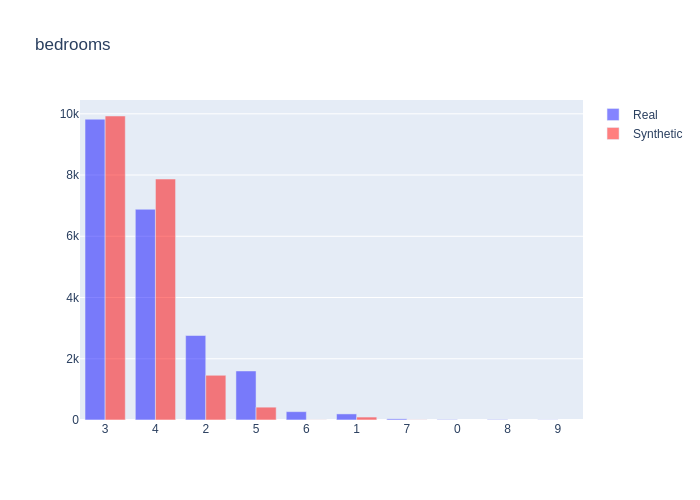

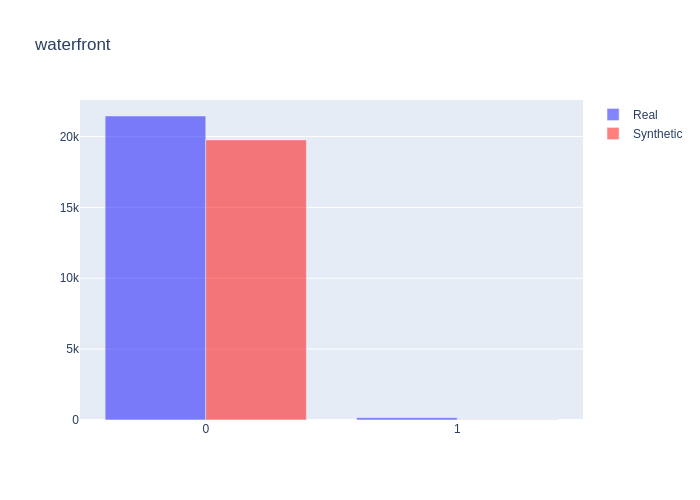

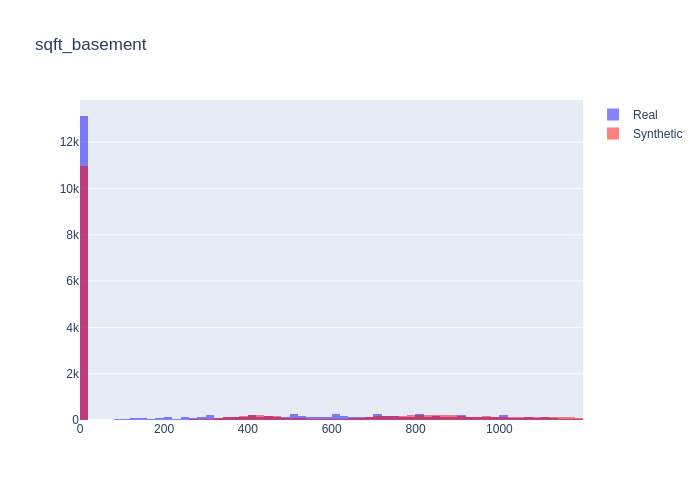

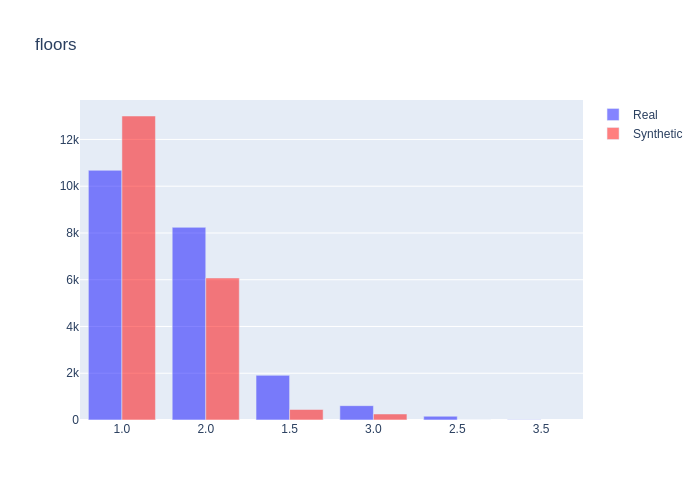

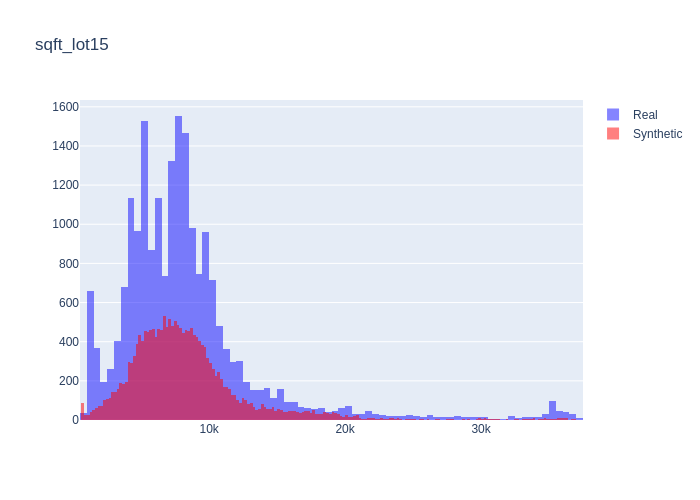

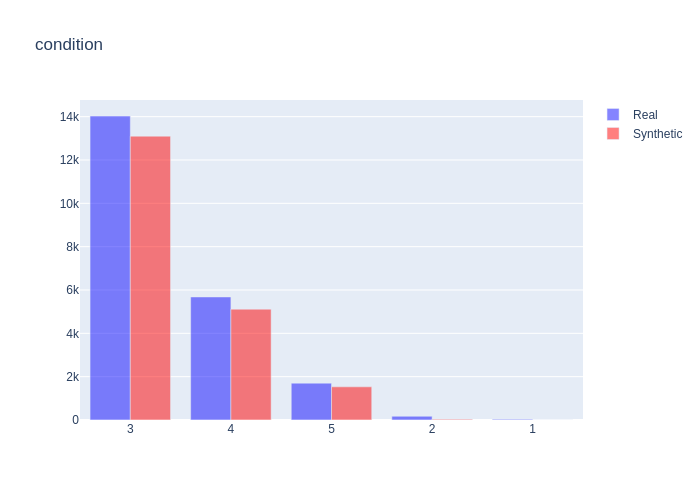

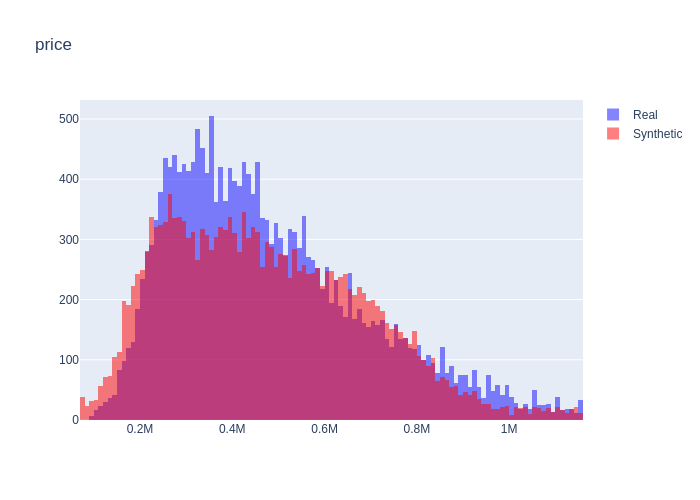

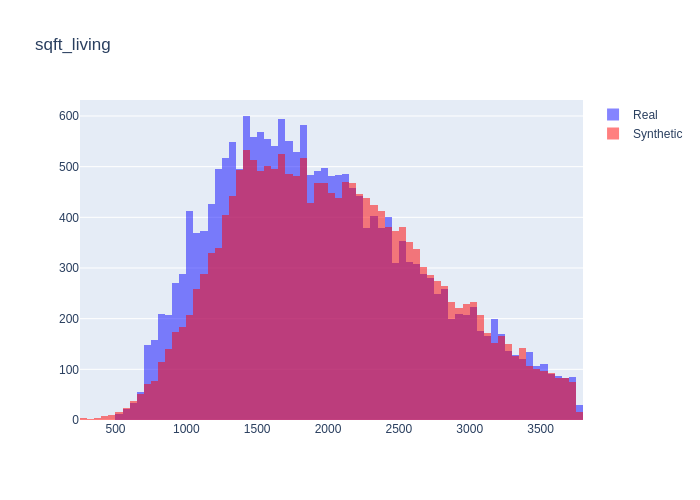

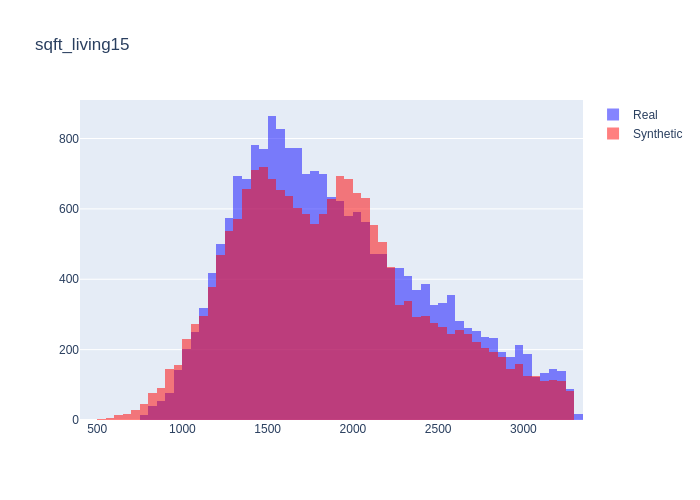

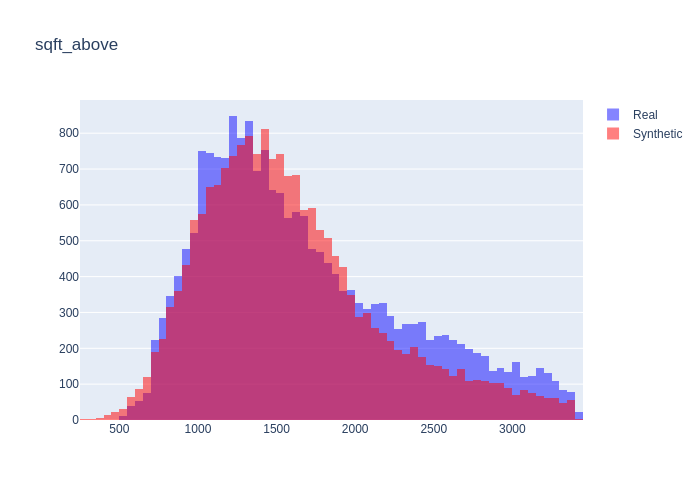

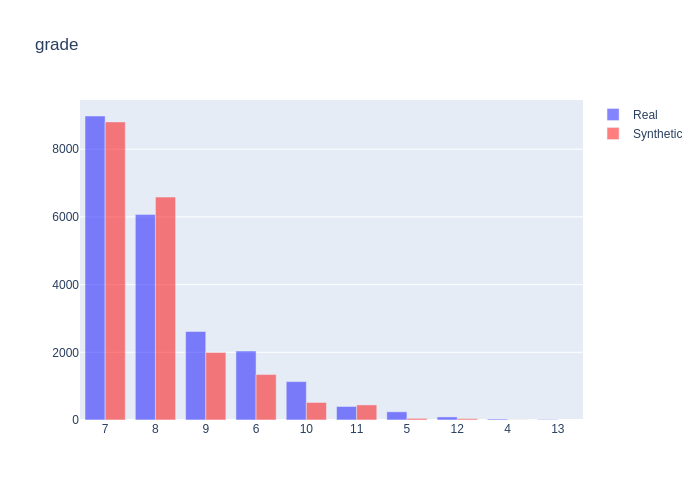

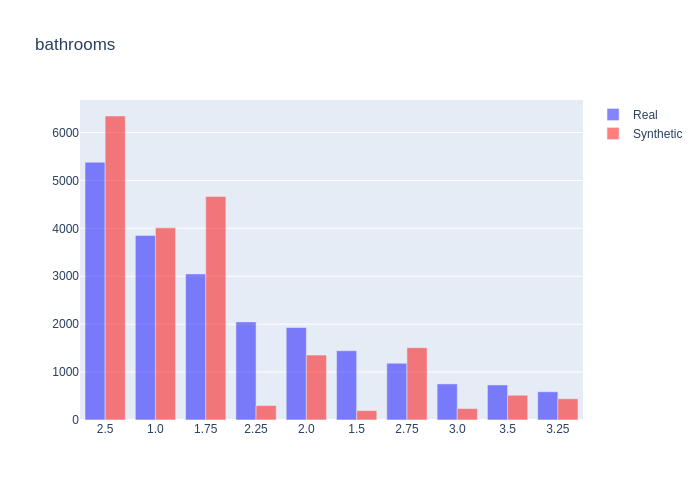

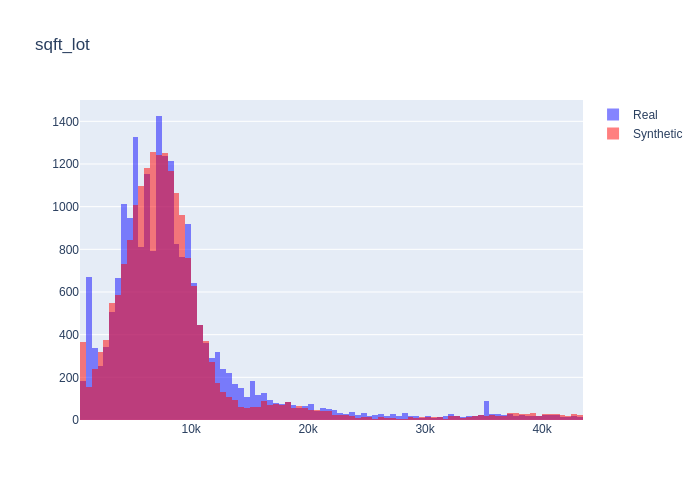

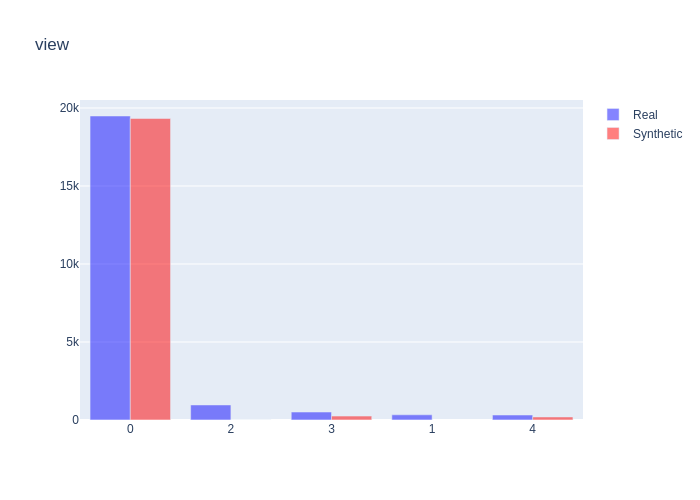

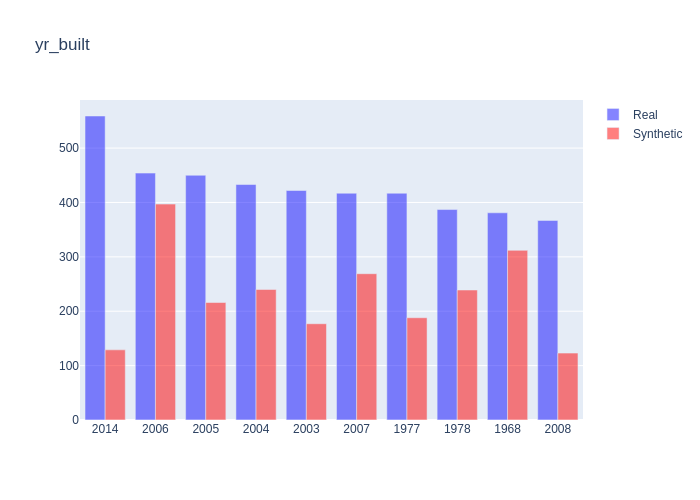

In [10]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts("tvae_wremain", {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        fig.show("png")

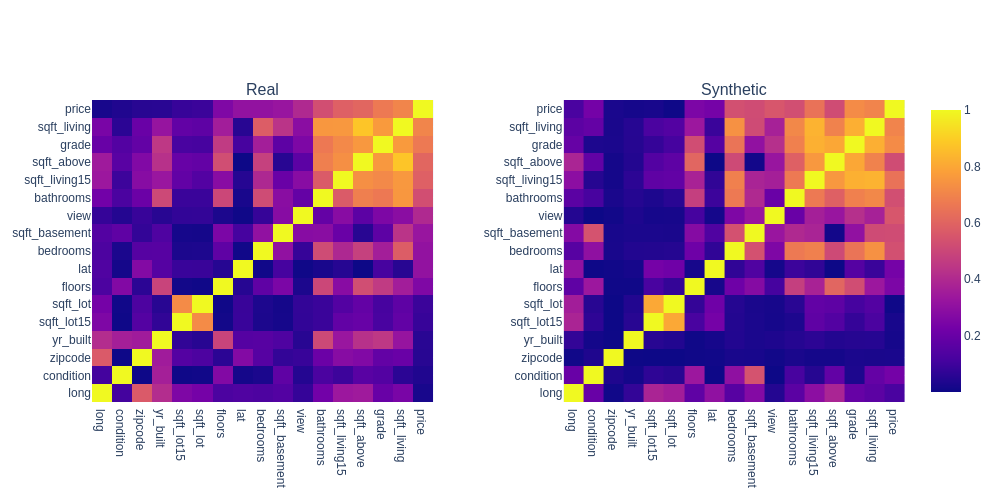

In [11]:
syn.charts.pair_corr(syn.df, syn.fake_data['tvae_wremain'], {'id', 'waterfront', 'yr_renovated'}, "price").update_layout(dict(width=1000)).show("png")